In [1]:
%load_ext autoreload
%autoreload 2

import nest
import sys
import os.path
import numpy as np
from math import degrees
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

sys.path.append('../')
import params
import nest_tools
import mnist_tools

# reseed numpy
np.random.seed(0)

# create samples

# load data - some preprocessing is done in the module (reshaping)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = mnist_tools.load_mnist_data('../mnist.pkl.gz')

# create pixel samples
pixel_samples = mnist_tools.create_samples(4000, sample_size=40)

######### rate 15000.000000000004


## LDA on raw digits - train on 900, evaluate on 100

In [3]:
data =   x_train[:900].reshape(-1,28*28)
labels = y_train[:900]

lda = LDA()
lda.fit(data, labels)

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [4]:
res = lda.predict(x_train[900:1000].reshape(-1,28*28))
print(np.sum(res == y_train[900:1000])/100)

0.58


## LDA on input vectors - train on 900, evaluate on 100

(900, 4000)


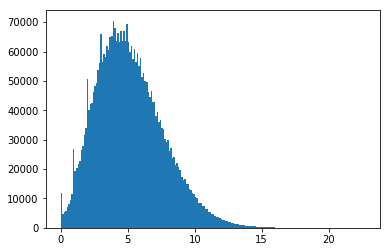

In [5]:
vectors = mnist_tools.digit_to_vectors(x_train[:900], pixel_samples)
activations = np.sum(vectors, axis=2)
print(activations.shape)
plt.hist(activations.ravel(), bins=200)
None

Now we train an LDA on the activations of the 4000 samples (which would be the input to the network)

In [6]:
lda2 = LDA()
lda2.fit(activations, y_train[:900])

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [7]:
val_vectors = mnist_tools.digit_to_vectors(x_train[900:1000], pixel_samples)
val_activations = np.sum(val_vectors, axis=2)

res = lda2.predict(val_activations)
print(np.sum(res == y_train[900:1000])/100)

0.57


## Simulate network and run LDA on output rates

In [8]:
def simulate(rates, digits, digit_labels, name, duration=1000.0):
    network = Network()
    network.reset_nest()
    network.setup_static_network()
    network.record_spikes(name)
    
    for i, digit in enumerate(digits):
        # set rate for every neuron

        for j, rate in enumerate(rates[i]):
            network.set_rate([j+1], rate)

        print(str(i+1)+". stimulus = "+str(digit_labels[i])+", simulating for", duration)
        nest.Simulate(duration)

    network.save_recording(name)

In [9]:
# uncomment to run simulations
input_rates = mnist_tools.calc_rates(x_train[:1000], pixel_samples, standardize_per_digit=True) * params.rate

if not os.path.exists('1000_digits.0.npy'):
    simulate(input_rates, x_train[:1000], y_train[:1000], '1000_digits')


In [11]:
recording = nest_tools.SpikeRecording.from_file('1000_digits')

0
20000000
30000000
40000000


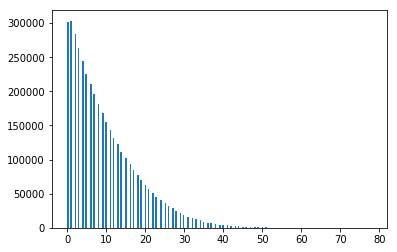

In [12]:
res = np.zeros((1000,4000))

for i in range(len(recording.times)):
    time = recording.times[i]
    sender = recording.senders[i]
    if sender <=4000:
        res[int(time/1000), sender-1] += 1
    
        if i % 10000000 == 0:
            print(i)
            
plt.hist(res.ravel(), bins=200)
None

In [13]:
lda3 = LDA()
lda3.fit(res[:900], y_train[:900])

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [14]:
r = lda3.predict(res[900:1000])
print(np.sum(r == y_train[900:1000])/100)

0.85
